In [41]:
import numpy as np
import pandas as pd
import emoji
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as pltclrs
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Embedding
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split  # Import for splitting the data
from gensim.models import KeyedVectors
from datetime import datetime
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report



np.random.seed(0)


In [2]:
data = pd.read_csv("data/emoji_data/emoji_data.csv", header=None)
data.head()

,0,1
0,Woke up feelin' dangerous,5
1,Got my mind on my money,5
2,Haha that was hilarious,1
3,Feeling like Uptown Funk,5
4,Congratulations for having a baby,2


Emoji Dictionary

In [3]:
emoji_dictionary = {
    0: ":red_heart:",  # Love #
    1: ":face_with_tears_of_joy:",  # Laughter
    2: ":grinning_face_with_big_eyes:", # Happiness #
    3: ":loudly_crying_face:",  # Sadness #
    4: ":smiling_face_with_heart-eyes:",  # Adoration
    5: ":fire:",  # Excitement
    6: ":thumbs_up:",  # Approval
    7: ":folded_hands:",  # Gratitude
    8: ":angry_face:",  # Anger
    9: ":thinking_face:",  # Contemplation
}


Function to get labels from CLDR names

In [4]:
def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[label])


Reading data

In [5]:
data = pd.read_csv('data/emoji_data/emoji_data.csv', header=None)
data.head()

,0,1
0,Woke up feelin' dangerous,5
1,Got my mind on my money,5
2,Haha that was hilarious,1
3,Feeling like Uptown Funk,5
4,Congratulations for having a baby,2


In [6]:

def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[label])

In [7]:
X = data[0].values
Y = data[1].values


Embeddings

With glove dataset

In [8]:
# with open('data/glove_dataset/glove.6B.100d.txt','r', encoding='utf8') as file:
#     content = file.readlines()

In [9]:
# embeddings = {}

# for line in content:
#     line = line.split()
#     embeddings[line[0]] = np.array(line[1:], dtype=float)

With crawl dataset

In [10]:
fasttext_model_path = "data/fast_text/crawl_dataset/crawl-300d-2M-subword.vec"
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path)


In [11]:
# Convert FastText embeddings to a dictionary
embeddings = {}
for word in fasttext_model.index_to_key:
    embeddings[word] = fasttext_model.get_vector(word)
    
    

Convert input text into tokens

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_to_index = tokenizer.word_index

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
Xtokens = tokenizer.texts_to_sequences(X)


In [14]:
def get_maxlen(data):
    maxlen = 0
    for sent in data:
        maxlen = max(maxlen, len(sent))
    
    return maxlen
maxlen = get_maxlen(Xtokens)



In [15]:
Xtrain = pad_sequences(Xtokens, maxlen=maxlen, padding='post', truncating='post')


In [16]:
Ytrain = to_categorical(Y)

Split data into train and test set

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=42)


Model

In [18]:
embed_size = 300

In [19]:
embedding_matrix = np.zeros((len(word_to_index) + 1, embed_size))

for word, i in word_to_index.items():
    if word in embeddings:
        embed_vector = embeddings[word]
        embedding_matrix[i] = embed_vector
    else:
        # Handle out-of-vocabulary words or phrases by aggregating subword embeddings
        phrase_embed_sum = None
        clean_word = re.split(r'\W+', word)
        for subword in clean_word:
            if subword in embeddings:
                if phrase_embed_sum is None:
                    phrase_embed_sum = embeddings[subword].copy()
                else:
                    phrase_embed_sum += embeddings[subword]
        # Assign the aggregated embedding to a new array with the desired dtype
        if phrase_embed_sum is not None:
            embedding_matrix[i] = phrase_embed_sum / len(clean_word)
            

            

In general more layers >>

In [20]:

epochs = 100


#units
layers = [256, 16, 4, 2]

num_layers = len(layers)


num_classes = len(emoji_dictionary)

Code to generate file name for saving model

In [21]:
def returnfilename():
    layers_str = '_'.join(map(str, layers))  # Convert layers to string and join them with '_'
    return f"epochs_{epochs}_layers_{layers_str}"


In [22]:
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=len(word_to_index) + 1,
                    output_dim=embed_size,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False))


# Add LSTM layers
for i in range(num_layers):
    # For the last layer, return_sequences=False
    if i == num_layers - 1:
        model.add(LSTM(units=layers[i]))
    else:
        model.add(LSTM(units=layers[i], return_sequences=True))

# Add output Dense layer
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
model.fit(Xtrain, Ytrain, epochs=epochs,  verbose = 1)

Epoch 1/100
24/24 [==============================] - 6s 21ms/step - loss: 2.2975 - accuracy: 0.1270
Epoch 2/100
24/24 [==============================] - 1s 21ms/step - loss: 2.2592 - accuracy: 0.1715
Epoch 3/100
24/24 [==============================] - 1s 22ms/step - loss: 2.2334 - accuracy: 0.1976
Epoch 4/100
24/24 [==============================] - 1s 21ms/step - loss: 2.2147 - accuracy: 0.2003
Epoch 5/100
24/24 [==============================] - 1s 21ms/step - loss: 2.1897 - accuracy: 0.2238
Epoch 6/100
24/24 [==============================] - 0s 21ms/step - loss: 2.1824 - accuracy: 0.2029
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 2.1553 - accuracy: 0.2317
Epoch 8/100
24/24 [==============================] - 1s 22ms/step - loss: 2.1425 - accuracy: 0.2421
Epoch 9/100
24/24 [==============================] - 1s 21ms/step - loss: 2.1136 - accuracy: 0.2435
Epoch 10/100
24/24 [==============================] - 1s 21ms/step - loss: 2.0922 - accuracy: 0.2539

In [24]:
filename = returnfilename()

In [25]:
model_save_path = "models/training set v.3.0/"

In [26]:

model_json = model.to_json()
with open(f"{model_save_path}/json/{filename}.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights(f"{model_save_path}/weights/{filename}.h5")



In [27]:
metrics_folder = f"{model_save_path}/metrics"

In [28]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime('%d %B, %Y')

# Write model architecture and details to file
with open(f"{metrics_folder}/{filename}.md", "w", encoding="utf-8") as file:
    file.write("# Model description:<br>\n")
    file.write(f"Date generated: {formatted_datetime}<br>\n")
    file.write(f"Number of classes: {num_classes}<br>\n")
    file.write(f"Number of samples: {len(X)}<br>\n")
    file.write(f"Training set size: {len(X_train)}<br>\n")
    file.write(f"Test set size: {len(X_test)}<br>\n")
    file.write(f"Epochs used: {epochs}<br>\n")
    file.write(f"Number of layers: {num_layers}<br>\n")
    file.write(f"Layers used: {layers}<br>\n")
    file.write("Optimizer: Adam<br>\n")
    file.write("Loss function: Categorical Crossentropy<br>\n")
    file.write("# Evaluation Results<br>\n")
    file.write(f"Test Loss: {loss:.4f}<br>\n")
    file.write(f"Test Accuracy: {accuracy:.4f}<br><br>\n")


5/5 [==============================] - 1s 8ms/step - loss: 1.2837 - accuracy: 0.5163
Test Loss: 1.2836791276931763
Test Accuracy: 0.516339898109436


In [29]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted and actual labels from one-hot encoded format to integer labels
Y_pred_labels = np.argmax(y_pred, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

# Compare predicted labels with actual labels
correct_predictions = np.sum(Y_pred_labels == Y_test_labels)
total_predictions = len(Y_test_labels)
accuracy = correct_predictions / total_predictions

# Print accuracy
print("Accuracy:", accuracy)
# Write accuracy to file
with open(f"{metrics_folder}/{filename}.md", "a", encoding="utf-8") as file:
    file.write("Accuracy: {:.4f}\n\n".format(accuracy))


# Write misclassified samples to file
with open(f"{metrics_folder}/{filename}.md", "a", encoding="utf-8") as file:
    file.write("## Misclassified samples:<br>\n")
    for i in range(len(Y_pred_labels)):
        if Y_pred_labels[i] != Y_test_labels[i]:
            file.write(
                f"Predicted: {label_to_emoji(Y_pred_labels[i])} Actual: {label_to_emoji(Y_test_labels[i])}<br>\n"
            )



for i in range(len(Y_pred_labels)):
    if Y_pred_labels[i]!=Y_test_labels[i]:
        print("Predicted:", label_to_emoji(Y_pred_labels[i]), "Actual:", label_to_emoji(Y_test_labels[i]))


5/5 [==============================] - 1s 8ms/step
Accuracy: 0.5163398692810458
Predicted: 😭 Actual: 🔥
Predicted: ❤️ Actual: 👍
Predicted: 😭 Actual: 🙏
Predicted: 😭 Actual: 🙏
Predicted: 😭 Actual: 🙏
Predicted: 🤔 Actual: 😠
Predicted: ❤️ Actual: 😃
Predicted: 😭 Actual: 🔥
Predicted: 😭 Actual: 🙏
Predicted: ❤️ Actual: 😍
Predicted: ❤️ Actual: 😍
Predicted: 🤔 Actual: 😠
Predicted: ❤️ Actual: 🙏
Predicted: 🤔 Actual: 🙏
Predicted: ❤️ Actual: 😍
Predicted: 😭 Actual: 🔥
Predicted: 😭 Actual: 🙏
Predicted: 😭 Actual: 🔥
Predicted: 😭 Actual: 🔥
Predicted: ❤️ Actual: 😍
Predicted: ❤️ Actual: 😃
Predicted: 😭 Actual: 🔥
Predicted: 😭 Actual: 🙏
Predicted: 🤔 Actual: 😠
Predicted: ❤️ Actual: 🙏
Predicted: 😭 Actual: 🙏
Predicted: 😭 Actual: 🔥
Predicted: ❤️ Actual: 🔥
Predicted: 🤔 Actual: 😠
Predicted: ❤️ Actual: 👍
Predicted: ❤️ Actual: 👍
Predicted: 😭 Actual: ❤️
Predicted: ❤️ Actual: 😍
Predicted: ❤️ Actual: 😍
Predicted: 🤔 Actual: 😠
Predicted: 😭 Actual: 🙏
Predicted: 🤔 Actual: 😠
Predicted: 😭 Actual: 🙏
Predicted: 🤔 Actual: 😠
Predicte

In [30]:
test = ["I am trying", "I want to cry", "This is just sad"]
actual_outputs = np.array([3,3,3])

test_seq = tokenizer.texts_to_sequences(test)
Xtest = pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')
y_pred = model.predict(Xtest)
y_pred = np.argmax(y_pred, axis=1)

# Write predictions to file
with open(f"{metrics_folder}/{filename}.md", "a", encoding="utf-8") as file:
    file.write("\n## Random test predictions: (accuracy based on discussion)<br>\n")
    for i in range(len(test)):
        file.write(f"{test[i]} {label_to_emoji(y_pred[i])}<br>\n")

1/1 [==============================] - 0s 25ms/step


In [31]:
for i in range(len(test)):
    print(test[i], label_to_emoji(y_pred[i]))

I am trying 😭
I want to cry 😭
This is just sad 😭


In [32]:
class_names = []

for i in range(len(emoji_dictionary)):
    class_names.append(label_to_emoji(i))
    
class_names

['❤️', '😂', '😃', '😭', '😍', '🔥', '👍', '🙏', '😠', '🤔']

c:\Users\nawsh\miniconda3\envs\myenv\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


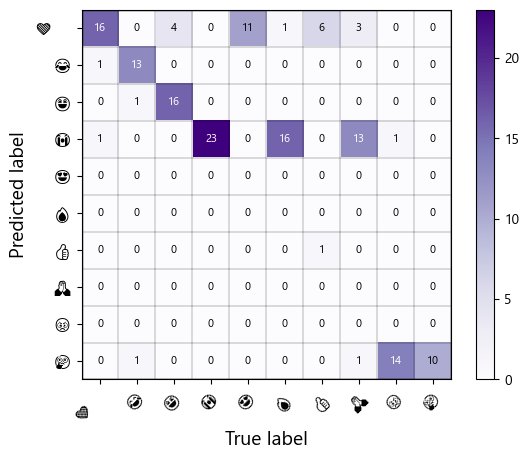

In [43]:

color = "Purples"

plt.rcParams['font.family'] = 'Segoe UI Emoji'


cf_matrix = confusion_matrix(Y_pred_labels, Y_test_labels)

# Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=class_names,
                                cmap=color)

# Add border around the entire matrix
ax.add_patch(plt.Rectangle((-0.5, -0.5), len(cf_matrix[0]), len(cf_matrix), color='black', fill=False, linewidth=1))

# Set custom axis labels
plt.ylabel('Predicted label', fontsize=14)  # Change the label for the x-axis
plt.xlabel('True label', fontsize=14)       # Change the label for the y-axis


# Draw outline around each cell
for i in range(len(cf_matrix)):
    for j in range(len(cf_matrix[i])):
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black', fill=False, linewidth=0.1))

# Adjust font size of the confusion matrix cells
for text in ax.texts:
    text.set_fontsize(8)  
    
plt.savefig(f"{model_save_path}/confusion_matrices/{filename}.png")

plt.show()


In [ ]:
print(classification_report())